2020/5/8
* changed auugmentations to kuzushiji augumentaitons.
* heatmaps points are smaller.
* Larger weights on regression targets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image

from nms import nms

import torch
import torchvision
from config.base import load_config

In [3]:
config = load_config("config/3x3_traincrop_rx101.yaml")

In [4]:
input_size = config.data["input_size"]
train_size = config.data["train_size"]

MODEL_SCALE = config.data["model_scale"]
FPN = config.model["fpn"]
try:
    bifpn = config.model["bifpn"]
except:
    bifpn = False
model_name = config.model["backbone"]
config.train["mixup"] = False

batch_size = 1
num_worker = config["num_workers"]
device = config["device"]
lr = config.optimizer.params["encoder_lr"]

TRAIN = False
CONTINUE = False

loadepoch = 54

IN_SCALE = input_size/train_size

###############
watermark = config["watermark"]
watermark

threshs = [0.2,0.3,0.4,0.5,0.6,0.7]
#threshs = [0.3]

In [5]:
model_name

'resnext101_32x4d'

## Prepare labels

In [6]:
from dataset import split
train_id, val_id, train_df, val_df = split.make_dfsplits(config)

## compile data processing

In [7]:
# Get augumentations
from aug import get_train_aug, get_val_aug
train_aug = get_train_aug(config)
val_aug = get_val_aug(config)

In [8]:
# import datasets
from dataset.dataset import WheatDataset
traindataset = WheatDataset(config, train_id, train_df, train_aug, train=True)
valdataset = WheatDataset(config, val_id, val_df, val_aug)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


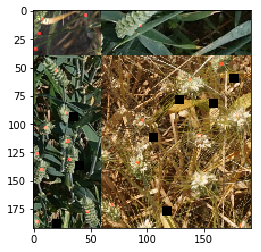

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


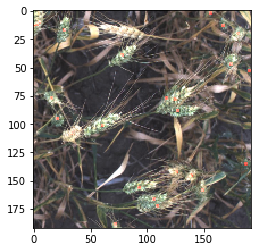

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


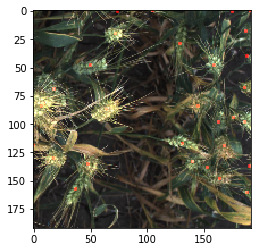

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


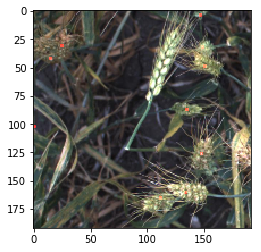

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


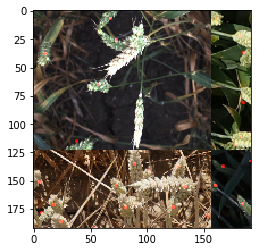

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


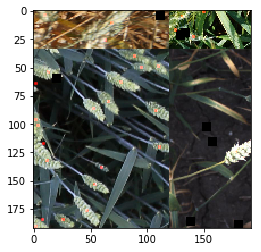

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


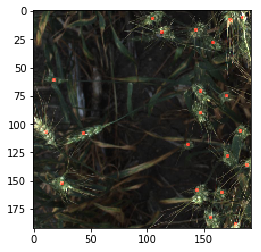

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


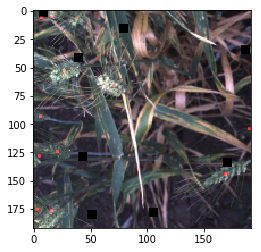

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


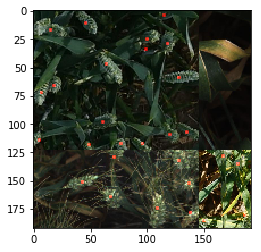

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


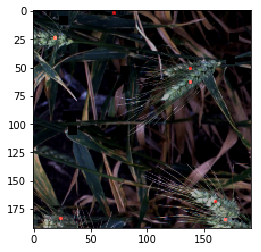

In [9]:
# Test dataset
for i in range(10):
    img, hm, regr = traindataset[i]
    hm = hm.numpy()
    regr = regr.numpy()
    img = img.permute(1,2,0).cpu().numpy()
    hm = np.array([hm, np.zeros_like(hm), np.zeros_like(hm)])
    plt.imshow(img[::4,::4,:] + hm.transpose([1,2,0]))
    plt.show()

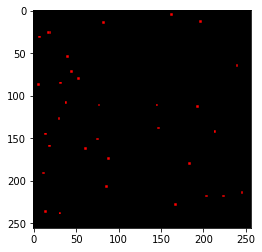

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


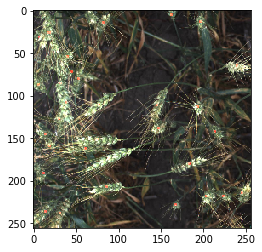

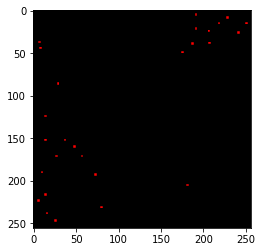

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


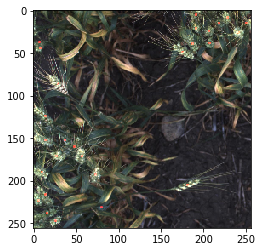

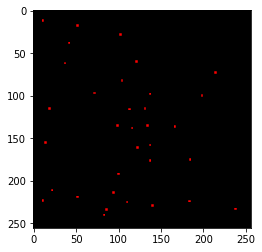

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


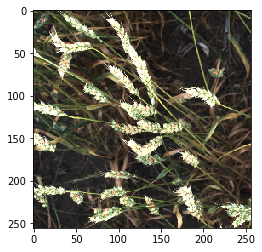

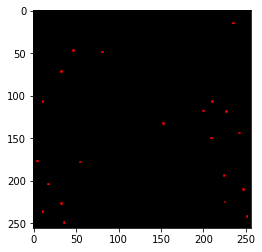

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


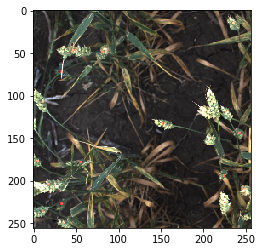

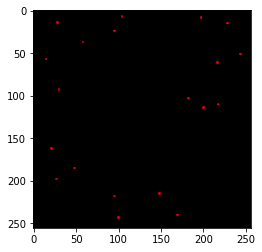

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


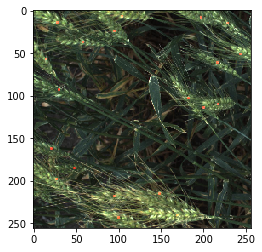

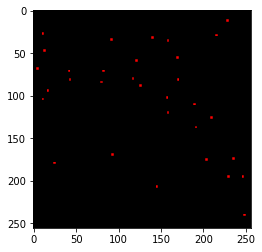

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


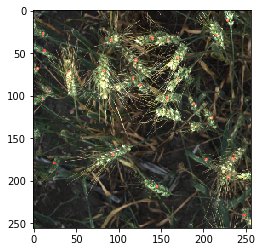

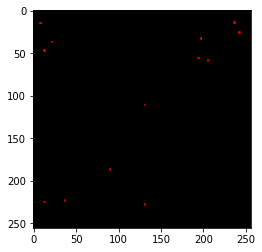

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


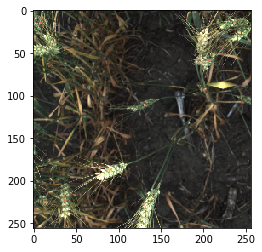

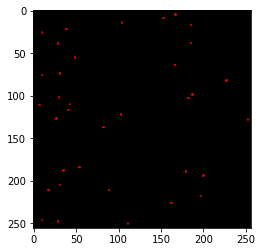

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


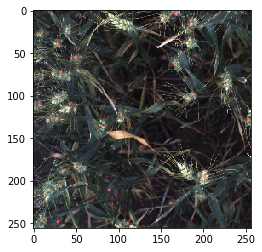

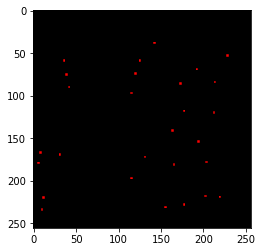

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


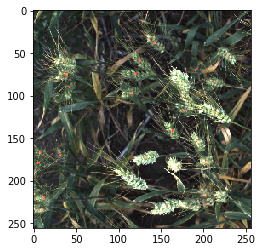

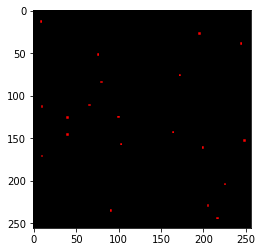

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


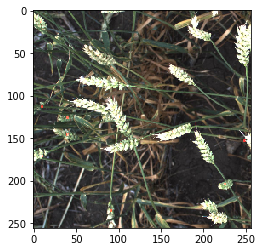

In [10]:
# Test dataset
for i in range(10):
    img, hm, regr = valdataset[i]
    hm = hm.numpy()
    regr = regr.numpy()
    img = img.permute(1,2,0).cpu().numpy()
    hm = np.array([hm, np.zeros_like(hm), np.zeros_like(hm)])
    plt.imshow(hm.transpose([1,2,0]))
    plt.show()
    plt.imshow(img[::4,::4,:] + hm.transpose([1,2,0]))
    plt.show()

In [11]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True, num_workers=num_worker)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=num_worker)

## Import models

In [12]:
from model import CenterNetFPN, centernet

model = CenterNetFPN("rx101", 4, bifpn=bifpn)


model

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_WSL-Images_master


CenterNetFPN(
  (fpn): FPN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): 

In [13]:
model.to(device)

# Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=lr)

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, min_lr=1e-3*1e-3, factor=0.3)

# Import loss

In [14]:
from loss import centerloss
criterion = centerloss

# Train function

In [15]:
from trainer.trainer import centernet_train, centernet_eval

# Load model

In [16]:
import gc
from line import LINENotifyBot
line = LINENotifyBot()

model.load_state_dict(torch.load('./models/rx101_FPN_3x3_aug2_48_1024_512.pth'))

<All keys matched successfully>

# Find best threshold

In [33]:
from ensemble_boxes import *
def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.45, skip_box_thr=0.5, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [34]:
model = model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(261, 4)
(13, 4)
GT boxes: (32, 4)


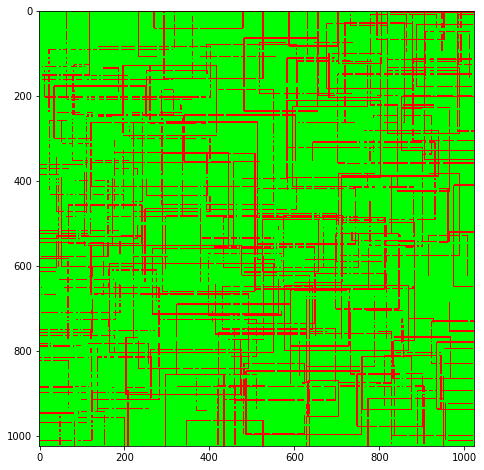

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(188, 4)
(15, 4)
GT boxes: (27, 4)


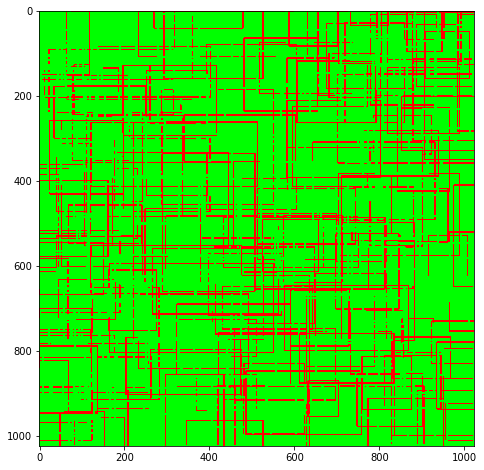

(753, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(30, 4)
GT boxes: (34, 4)


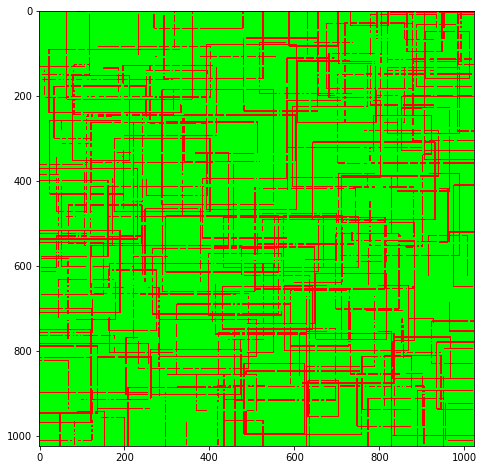

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(350, 4)
(20, 4)
GT boxes: (21, 4)


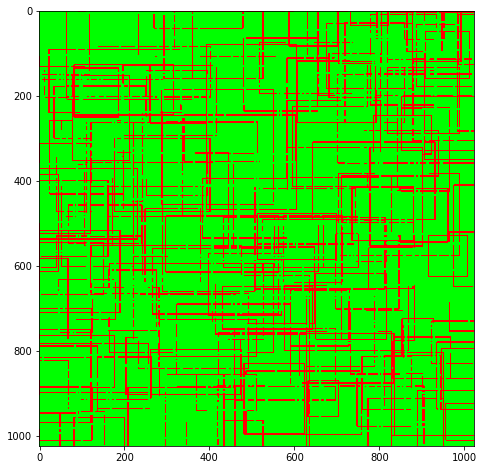

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 4)
(9, 4)
GT boxes: (20, 4)


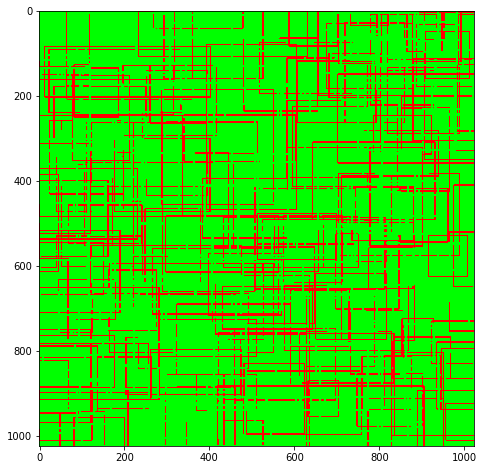

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(190, 4)
(12, 4)
GT boxes: (32, 4)


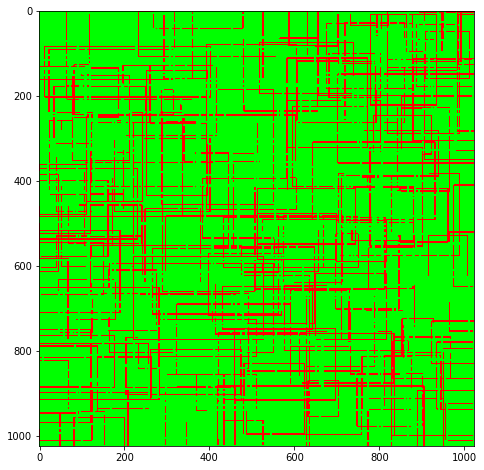

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(84, 4)
(5, 4)
GT boxes: (13, 4)


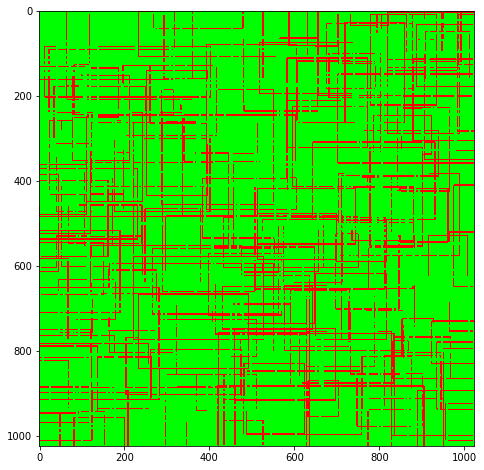

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(156, 4)
(9, 4)
GT boxes: (35, 4)


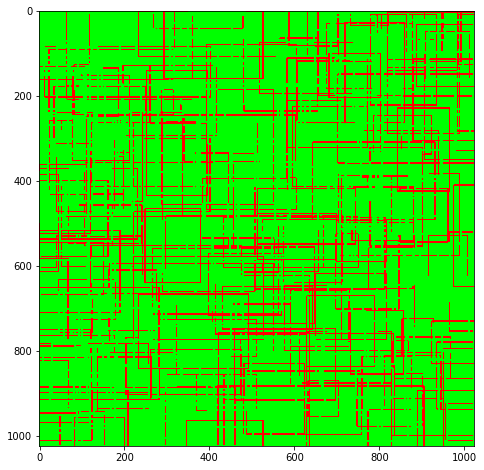

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(273, 4)
(14, 4)
GT boxes: (28, 4)


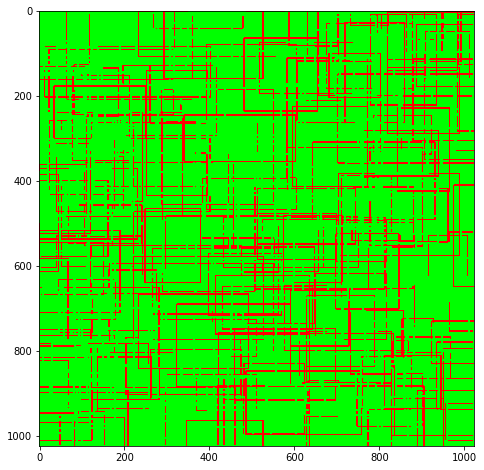

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(550, 4)
(23, 4)
GT boxes: (20, 4)


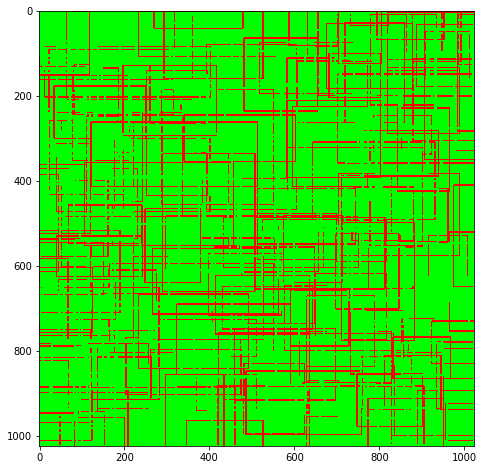

In [41]:
from dataset.dataset import showbox, showgtbox, pred2box

for id in range(10):
    img, hm_gt, regr_gt = valdataset[id]
    with torch.no_grad():
        hm, regr = model(img.to(device).float().unsqueeze(0))
    
    img = img.cpu().numpy().transpose([1,2,0])
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    regr = regr.cpu().numpy().squeeze(0) / (input_size/train_size)

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hmm = np.array([hm, np.zeros_like(hm), np.zeros_like(hm)]).transpose([1,2,0])
    img2 = (img[::4, ::4, :] + (hmm).astype("int"))
    
    boxes, scores = pred2box(config,hm, regr[:2], regr[2:], 0.2)
    boxes = coco2pascal(boxes).astype("int32")
    preds = [[{"boxes":boxes, "scores": scores}]]
    print(boxes.shape)
    boxes, scores, labels = run_wbf(preds, 0, skip_box_thr=0.2)
    print(boxes.shape)
    boxes = (boxes).astype("int32")
    
    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2],  box[3]), (1, 0, 0), 2)
    
    # show gt
    sample = showgtbox(config, sample, hm_gt, regr_gt[:2], regr_gt[2:], 0.999)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.show()

In [20]:
from metric import calculate_precision, calculate_image_precision
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

In [28]:
# entire val dataset


idx = 0
log = []
precision05 = np.zeros(len(threshs))
precisions = np.zeros(len(threshs))
torch.cuda.empty_cache()

idx = 0
precision05 = np.zeros(len(threshs))
precisions = np.zeros(len(threshs))
torch.cuda.empty_cache()
for img, hm_gts, regr_gts in tqdm(val_loader):
    # send to gpu
    img = img.to(device)
    hm_gts = hm_gts.numpy()
    regr_gts = regr_gts.numpy()

    # predict
    with torch.no_grad():
        hms, regrs = model(img.to(device).float())

    # calculate mAP
    for t,thresh in enumerate(threshs):
        p05 = []
        ps = []
        for hm, regr, hm_gt, regr_gt  in zip(hms, regrs, hm_gts, regr_gts):
            # process predictions
            hm = hm.cpu().numpy().squeeze(0)
            regr = regr.cpu().numpy()  / (input_size/train_size)
            hm = torch.sigmoid(torch.from_numpy(hm)).numpy()

            boxes_gt, scores_gt = pred2box(config,hm_gt, regr_gt[:2], regr_gt[2:], 0.99)
            boxes, scores = pred2box(config,hm, regr[:2], regr[2:], 0.1)

            # Filter by nms
            from utils import pascal2coco, coco2pascal
            boxes = coco2pascal(boxes)
            preds = [[{"boxes":boxes, "scores": scores}]]
            boxes, scores, labels = run_wbf(preds, 0, skip_box_thr=thresh)
            
            boxes = pascal2coco(boxes)

            precision, fn_boxes, fp_boxes = calculate_precision(boxes, boxes_gt, threshold=0.5, form='coco')
            p05.append(precision)

            image_precision = calculate_image_precision(boxes, boxes_gt,
                                                thresholds=iou_thresholds,
                                                form='coco', debug=False)
            ps.append(image_precision)

        precision05[t] += np.mean(p05)
        precisions[t] += np.mean(ps)
    idx += 1

# evaluate mAP based on each source
result = {"watermark": watermark, "threshs": threshs, "map50": precision05/idx, "map5075": precisions/idx, }
log.append(result)

df = pd.DataFrame(log)
df.to_csv("results/log_eval_evals_{}_{}.csv".format(watermark, input_size))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

In [ ]:
df

In [29]:
precision05/idx

array([0., 0., 0., 0., 0., 0.])

# Evaluate by source

In [ ]:
import pandas as pd

log = []

# get x sources
image_source = val_df[['source']].drop_duplicates().to_numpy()

# make df per source
for source in image_source:
    print("evaluating for:", source)
    source_df = val_df[val_df['source'].isin(source)]
    source_id = source_df['image_id'].drop_duplicates().to_numpy()
    valdataset = WheatDataset(config, source_id, source_df, val_aug)
    val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=num_worker)
    idx = 0
    precision05 = np.zeros(len(threshs))
    precisions = np.zeros(len(threshs))
    for img, hm_gts, regr_gts in tqdm(val_loader):
        # send to gpu
        img = img.to(device)
        hm_gts = hm_gts.numpy()
        regr_gts = regr_gts.numpy()

        # predict
        with torch.no_grad():
            hms, regrs = model(img.to(device).float())

        # calculate mAP
        for t,thresh in enumerate(threshs):
            p05 = []
            ps = []
            for hm, regr, hm_gt, regr_gt  in zip(hms, regrs, hm_gts, regr_gts):
                # process predictions
                hm = hm.cpu().numpy().squeeze(0)
                regr = regr.cpu().numpy()  / (input_size/train_size)
                hm = torch.sigmoid(torch.from_numpy(hm)).numpy()

                boxes_gt, scores_gt = pred2box(config,hm_gt, regr_gt[:2], regr_gt[2:], 0.99)
                boxes, scores = pred2box(config,hm, regr[:2], regr[2:], thresh)

                # Filter by nms
                keep, count = nms(boxes, scores, top_k=2000)
                boxes = boxes[keep[:count]]
                scores = scores[keep[:count]]

                preds_sorted_idx = np.argsort(scores)[::-1]
                boxes_sorted = boxes[preds_sorted_idx]

                precision, fn_boxes, fp_boxes = calculate_precision(boxes_sorted, boxes_gt, threshold=0.5, form='coco')
                p05.append(precision)

                image_precision = calculate_image_precision(boxes_sorted, boxes_gt,
                                                    thresholds=iou_thresholds,
                                                    form='coco', debug=False)
                ps.append(image_precision)

            precision05[t] += np.mean(p05)
            precisions[t] += np.mean(ps)
        idx += 1
        
    print("mAP at threshold 0.5: {}".format(precision05/idx))
    print("mAP at threshold 0.5:0.75: {}".format(precisions/idx))
    map50 = precision05/idx
    map5075 = precisions/idx
    # evaluate mAP based on each source
    result = {"source": source, "watermark": watermark, "threshs":threshs, "map50": map50, "map5075": map5075, "num_images": len(source_id)}
    log.append(result)
    
df = pd.DataFrame(log)
df.to_csv("results/log_eval_sources_{}_{}.csv".format(watermark, input_size))

In [ ]:
df

In [ ]:
import ttach as tta
import torch.nn as nn
class model2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        hm, regr = self.model(x)
        return torch.cat((hm, regr), axis=1)

# defined 2 * 2 * 3 * 3 = 36 augmentations !
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
        tta.Rotate90(angles=[0, 180]),
        #tta.Multiply(factors=[0.9, 1, 1.1]),
        #tta.FiveCrops(768, 768),        
    ]
)
    
model3 = model2(model)
tta_model = tta.SegmentationTTAWrapper(model3, transforms)

In [ ]:
valdataset = WheatDataset(config, val_id, val_df, val_aug)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=num_worker)

In [ ]:
# entire val dataset
from metric import calculate_precision, calculate_image_precision
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

idx = 0
precision05 = np.zeros(len(threshs))
precisions = np.zeros(len(threshs))
torch.cuda.empty_cache()
log = []

for img, hm_gts, regr_gts in tqdm(val_loader):
    # send to gpu
    img = img.to(device)
    hm_gts = hm_gts.numpy()
    regr_gts = regr_gts.numpy()

    # predict
    with torch.no_grad():
        outs = tta_model(img.to(device).float())
        hms = outs[:,0:1]
        regrs = outs[:,1:]
    
    # calculate mAP
    for t,thresh in enumerate(threshs):
        p05 = []
        ps = []
        for hm, regr, hm_gt, regr_gt  in zip(hms, regrs, hm_gts, regr_gts):
            # process predictions
            hm = hm.cpu().numpy().squeeze(0)
            regr = regr.cpu().numpy()  / (input_size/train_size)
            hm = torch.sigmoid(torch.from_numpy(hm)).numpy()

            boxes_gt, scores_gt = pred2box(config,hm_gt, regr_gt[:2], regr_gt[2:], 0.99)
            boxes, scores = pred2box(config,hm, regr[:2], regr[2:], thresh)

            # Filter by nms
            keep, count = nms(boxes, scores, top_k=2000)
            boxes = boxes[keep[:count]]
            scores = scores[keep[:count]]

            preds_sorted_idx = np.argsort(scores)[::-1]
            boxes_sorted = boxes[preds_sorted_idx]

            precision, fn_boxes, fp_boxes = calculate_precision(boxes_sorted, boxes_gt, threshold=0.5, form='coco')
            p05.append(precision)

            image_precision = calculate_image_precision(boxes_sorted, boxes_gt,
                                                thresholds=iou_thresholds,
                                                form='coco', debug=False)
            ps.append(image_precision)
            
        precision05[t] += np.mean(p05)
        precisions[t] += np.mean(ps)
    idx += 1
    
# evaluate mAP based on each source
result = {"watermark": watermark, "threshs": threshs, "map50": precision05/idx, "map5075": precisions/idx, }
log.append(result)
    
df = pd.DataFrame(log)
df.to_csv("results/log_eval_evals_tta_{}_{}.csv".format(watermark, input_size))

In [ ]:
df

In [ ]:
import pandas as pd

log = []

# get x sources
image_source = val_df[['source']].drop_duplicates().to_numpy()

# make df per source
for source in image_source:
    print("evaluating for:", source)
    source_df = val_df[val_df['source'].isin(source)]
    source_id = source_df['image_id'].drop_duplicates().to_numpy()
    valdataset = WheatDataset(config, source_id, source_df, val_aug)
    val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=num_worker)
    idx = 0
    precision05 = np.zeros(len(threshs))
    precisions = np.zeros(len(threshs))
    for img, hm_gts, regr_gts in tqdm(val_loader):
        # send to gpu
        img = img.to(device)
        hm_gts = hm_gts.numpy()
        regr_gts = regr_gts.numpy()

        # predict
        with torch.no_grad():
            outs = tta_model(img.to(device).float())
            hms = outs[:,0:1]
            regrs = outs[:,1:]

        # calculate mAP
        for t,thresh in enumerate(threshs):
            p05 = []
            ps = []
            for hm, regr, hm_gt, regr_gt  in zip(hms, regrs, hm_gts, regr_gts):
                # process predictions
                hm = hm.cpu().numpy().squeeze(0)
                regr = regr.cpu().numpy()  / (input_size/train_size)
                hm = torch.sigmoid(torch.from_numpy(hm)).numpy()

                boxes_gt, scores_gt = pred2box(config,hm_gt, regr_gt[:2], regr_gt[2:], 0.99)
                boxes, scores = pred2box(config,hm, regr[:2], regr[2:], thresh)

                # Filter by nms
                keep, count = nms(boxes, scores, top_k=2000)
                boxes = boxes[keep[:count]]
                scores = scores[keep[:count]]

                preds_sorted_idx = np.argsort(scores)[::-1]
                boxes_sorted = boxes[preds_sorted_idx]

                precision, fn_boxes, fp_boxes = calculate_precision(boxes_sorted, boxes_gt, threshold=0.5, form='coco')
                p05.append(precision)

                image_precision = calculate_image_precision(boxes_sorted, boxes_gt,
                                                    thresholds=iou_thresholds,
                                                    form='coco', debug=False)
                ps.append(image_precision)

            precision05[t] += np.mean(p05)
            precisions[t] += np.mean(ps)
        idx += 1
        
    print("mAP at threshold 0.5: {}".format(precision05/idx))
    print("mAP at threshold 0.5:0.75: {}".format(precisions/idx))
    map50 = precision05/idx
    map5075 = precisions/idx
    # evaluate mAP based on each source
    result = {"source": source, "watermark": watermark, "threshs":threshs, "map50": map50, "map5075": map5075, "num_images": len(source_id)}
    log.append(result)
    
df = pd.DataFrame(log)
df.to_csv("results/log_eval_sources__tta_{}_{}.csv".format(watermark, input_size))

In [ ]:
df